### Basic Modules

In [6]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import os
import h5py
import pickle
from typing import *
from functools import partial

In [7]:
from pathlib import Path
PATH = Path('data/top/')

In [8]:
trn_store = pd.HDFStore(PATH/'train.h5')

In [9]:
import torch

In [10]:
torch.cuda.current_device()

0

In [11]:
def load_df(store:pd.io.pytables.HDFStore, n_evts:Optional[int]=None, n_const:Optional[int]=None) -> pd.DataFrame:
    df = trn_store.select("table",stop=n_evts).drop(columns=['truthE','truthPX','truthPY','truthPZ','ttv'])
    if n_const is not None: df.drop(columns=[f for f in df.columns if f != 'is_signal_new' and int(f[f.find('_')+1:]) >= n_const], inplace=True)
    rename = {f:f'{f[f.find("_")+1:]}_{f[:f.find("_")].lower()}' for f in df.columns if f != 'is_signal_new'}
    rename['is_signal_new'] = 'gen_target'
    df.rename(columns=rename, inplace=True)
    return df

In [12]:
df = load_df(trn_store, None, 15)
train_feats = [f for f in df.columns if f != 'gen_target']
train_feats

['0_e',
 '0_px',
 '0_py',
 '0_pz',
 '1_e',
 '1_px',
 '1_py',
 '1_pz',
 '2_e',
 '2_px',
 '2_py',
 '2_pz',
 '3_e',
 '3_px',
 '3_py',
 '3_pz',
 '4_e',
 '4_px',
 '4_py',
 '4_pz',
 '5_e',
 '5_px',
 '5_py',
 '5_pz',
 '6_e',
 '6_px',
 '6_py',
 '6_pz',
 '7_e',
 '7_px',
 '7_py',
 '7_pz',
 '8_e',
 '8_px',
 '8_py',
 '8_pz',
 '9_e',
 '9_px',
 '9_py',
 '9_pz',
 '10_e',
 '10_px',
 '10_py',
 '10_pz',
 '11_e',
 '11_px',
 '11_py',
 '11_pz',
 '12_e',
 '12_px',
 '12_py',
 '12_pz',
 '13_e',
 '13_px',
 '13_py',
 '13_pz',
 '14_e',
 '14_px',
 '14_py',
 '14_pz']

In [13]:
from lumin.data_processing.pre_proc import fit_input_pipe

def proc_df(df:pd.DataFrame, train_feats:List[str]) -> None:
    df[train_feats] = df[train_feats].replace(0.0, np.nan)  # Don't bias preprocessing with non-existent tracks
    input_pipe = fit_input_pipe(df, train_feats, PATH/'input_pipe')
    df[train_feats] = input_pipe.transform(df[train_feats])  # Rescale and shift track momenta values

In [14]:
proc_df(df, train_feats)

/home/giles/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [15]:
from lumin.data_processing.hep_proc import get_vecs

fpv = ['px', 'py', 'pz', 'e']
vecs = sorted(list(get_vecs(train_feats)))
fpv, vecs

(['px', 'py', 'pz', 'e'],
 ['0',
  '1',
  '10',
  '11',
  '12',
  '13',
  '14',
  '2',
  '3',
  '4',
  '5',
  '6',
  '7',
  '8',
  '9'])

In [32]:
from lumin.data_processing.file_proc import df2foldfile
from lumin.nn.data.fold_yielder import *

def df2fy(df:pd.DataFrame, train_feats:List[str], vecs:Optional[List[str]]=None, feats_per_vec:Optional[List[str]]=None,
            row_wise:Optional[bool]=None, use_aug:bool=True, n_folds:int=10) -> FoldYielder:
    df2foldfile(df=df, n_folds=n_folds,
                cont_feats=train_feats, cat_feats=[], targ_feats='gen_target',
                matrix_feats_per_vec=feats_per_vec, matrix_vecs=vecs, matrix_row_wise=row_wise,
                savename=PATH/'train', targ_type='int', strat_key='gen_target')
    if vecs is None: return HEPAugFoldYielder(PATH/'train.hdf5') if use_aug else FoldYielder(PATH/'train.hdf5')
    else:            return FoldYielder(PATH/'train.hdf5')

In [33]:
train_fy = df2fy(df, train_feats, use_aug=True, n_folds=20)

Saving fold 0 with 60551 events
Saving fold 1 with 60551 events
Saving fold 2 with 60551 events
Saving fold 3 with 60550 events
Saving fold 4 with 60550 events
Saving fold 5 with 60550 events
Saving fold 6 with 60550 events
Saving fold 7 with 60550 events
Saving fold 8 with 60550 events
Saving fold 9 with 60550 events
Saving fold 10 with 60550 events
Saving fold 11 with 60550 events
Saving fold 12 with 60550 events
Saving fold 13 with 60550 events
Saving fold 14 with 60550 events
Saving fold 15 with 60550 events
Saving fold 16 with 60550 events
Saving fold 17 with 60549 events
Saving fold 18 with 60549 events
Saving fold 19 with 60549 events
Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 8


In [34]:
from lumin.nn.models.model_builder import ModelBuilder
from lumin.nn.models.model import Model
from lumin.nn.models.blocks.body import FullyConnected
from lumin.nn.models.helpers import CatEmbedder
from lumin.nn.models.blocks.head import *
from lumin.nn.models.blocks.head import AbsHead
from typing import *
from torch import nn

In [35]:
bs = 1024
objective = 'classifier'
n_out = 1

def get_model_builder(fy:FoldYielder, depth:int, width:int, head:AbsHead=CatEmbHead) -> ModelBuilder:
    opt_args = {'opt':'adam', 'eps':1e-08}
    cat_embedder = CatEmbedder.from_fy(fy)
    body = partial(FullyConnected, depth=depth, width=width, act='swish')
    model_builder = ModelBuilder(objective, cont_feats=fy.cont_feats, n_out=n_out, cat_embedder=cat_embedder, 
                                 opt_args=opt_args, body=body, head=head)
    print(Model(model_builder))
    return model_builder

## DNN

In [17]:
model_builder = get_model_builder(train_fy, depth=4, width=50)

Inputs:
60 Continuous: ['0_e', '0_px', '0_py', '0_pz', '1_e', '1_px', '1_py', '1_pz', '2_e', '2_px', '2_py', '2_pz', '3_e', '3_px', '3_py', '3_pz', '4_e', '4_px', '4_py', '4_pz', '5_e', '5_px', '5_py', '5_pz', '6_e', '6_px', '6_py', '6_pz', '7_e', '7_px', '7_py', '7_pz', '8_e', '8_px', '8_py', '8_pz', '9_e', '9_px', '9_py', '9_pz', '10_e', '10_px', '10_py', '10_pz', '11_e', '11_px', '11_py', '11_pz', '12_e', '12_px', '12_py', '12_pz', '13_e', '13_px', '13_py', '13_pz', '14_e', '14_px', '14_py', '14_pz']
                   
0  Categorical: []
                   
0  Matrix elements: []
                   

Model:
<bound method Module.parameters of Sequential(
  (0): CatEmbHead()
  (1): FullyConnected(
    (layers): Sequential(
      (0): Sequential(
        (0): Linear(in_features=60, out_features=50, bias=True)
        (1): Swish()
      )
      (1): Sequential(
        (0): Linear(in_features=50, out_features=50, bias=True)
        (1): Swish()
      )
      (2): Sequential(
        (0

In [20]:
from lumin.optimisation.hyper_param import fold_lr_find

lr_finder = fold_lr_find(train_fy, model_builder, bs, lr_bounds=[1e-6,1e0])

NameError: name 'model_builder' is not defined

In [21]:
from sklearn.metrics import roc_auc_score
from lumin.nn.metrics.eval_metric import EvalMetric

class AUC(EvalMetric):
    def __init__(self, wgt_name:Optional[str]=None, targ_name:str='targets'):
        super().__init__(targ_name=targ_name, wgt_name=wgt_name)

    def evaluate(self, fy:FoldYielder, idx:int, y_pred:np.ndarray) -> float:
        df = self.get_df(fy, idx, y_pred)
        return roc_auc_score(df['gen_target'], df['pred'])

In [22]:
from lumin.nn.callbacks.cyclic_callbacks import *
from functools import partial

callback_partials = [partial(OneCycle, lengths=[45, 90], lr_range=[1e-4, 1e-2], mom_range=[0.85, 0.95], interp='cosine')]
eval_metrics = {'AUC':AUC(wgt_name='weights')}

In [23]:
from lumin.nn.training.fold_train import fold_train_ensemble

_ = fold_train_ensemble(train_fy, n_models=1,
                        model_builder=model_builder,
                        bs=bs,
                        callback_partials=callback_partials,
                        eval_metrics=eval_metrics,
                        max_epochs=15, patience=15)

NameError: name 'model_builder' is not defined

## RNN

In [27]:
head = partial(RecurrentHead, vecs=vecs, feats_per_vec=fpv,
               depth=3, width=10, rnn=nn.GRU, bidirectional=True)
model_builder = get_model_builder(train_fy, depth=3, width=50, head=head)

Inputs:
60 Continuous: ['0_e', '0_px', '0_py', '0_pz', '1_e', '1_px', '1_py', '1_pz', '2_e', '2_px', '2_py', '2_pz', '3_e', '3_px', '3_py', '3_pz', '4_e', '4_px', '4_py', '4_pz', '5_e', '5_px', '5_py', '5_pz', '6_e', '6_px', '6_py', '6_pz', '7_e', '7_px', '7_py', '7_pz', '8_e', '8_px', '8_py', '8_pz', '9_e', '9_px', '9_py', '9_pz', '10_e', '10_px', '10_py', '10_pz', '11_e', '11_px', '11_py', '11_pz', '12_e', '12_px', '12_py', '12_pz', '13_e', '13_px', '13_py', '13_pz', '14_e', '14_px', '14_py', '14_pz']
                   
0  Categorical: []
                   
0  Matrix elements: []
                   

Model:
<bound method Module.parameters of Sequential(
  (0): RecurrentHead(
    (rnn): GRU(4, 10, num_layers=3, batch_first=True, bidirectional=True)
  )
  (1): FullyConnected(
    (layers): Sequential(
      (0): Sequential(
        (0): Linear(in_features=20, out_features=50, bias=True)
        (1): Swish()
      )
      (1): Sequential(
        (0): Linear(in_features=50, out_featur

LR finder took 61.713s 


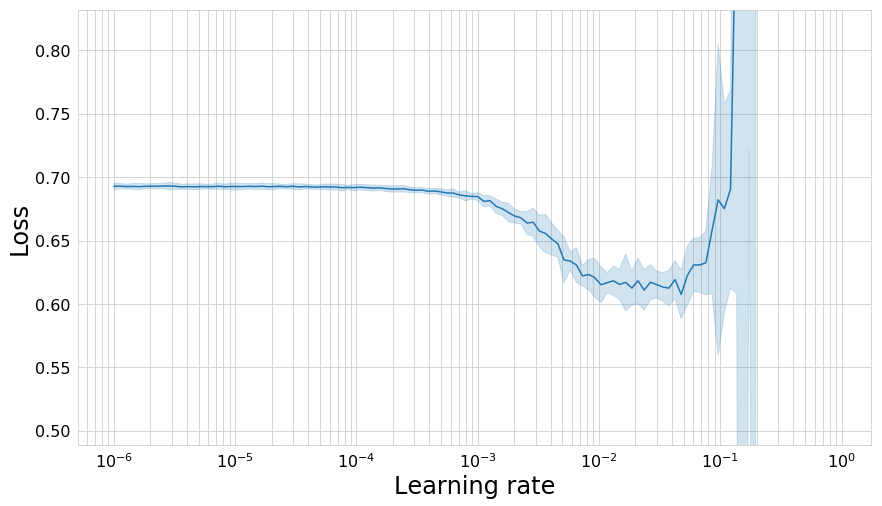

In [29]:
lr_finder = fold_lr_find(train_fy, model_builder, bs, lr_bounds=[1e-6,1e0])

Training model 1 / 1, Val ID = 0


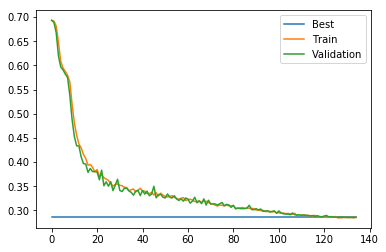

Early stopping after 135 epochs
Scores are: {'loss': 0.2855236232280731, 'AUC': 0.9405833367057035}
Fold took 671.669s


______________________________________
Training finished
Cross-validation took 671.678s 


<Figure size 432x288 with 0 Axes>

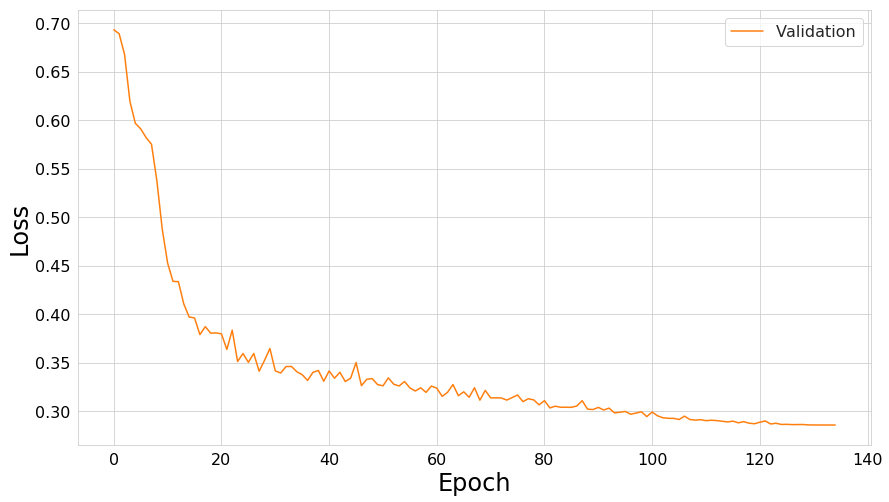

Mean loss = 0.2855236232280731±0.0
Mean AUC = 0.9405833367057035±0.0
______________________________________



In [30]:
_ = fold_train_ensemble(train_fy, n_models=1,
                        model_builder=model_builder,
                        bs=bs,
                        callback_partials=callback_partials,
                        eval_metrics=eval_metrics,
                        max_epochs=15, patience=15)

## CNN

In [36]:
class CNN(AbsConv1dHead):
    def get_layers(self, in_c:int, act:str='relu', bn:bool=False, **kargs) -> Tuple[nn.Module, int]:    
        layers = []
        layers.append(self.get_conv1d_block(in_c, 16, stride=1, kernel_sz=3, act=act, bn=bn))
        layers.append(self.get_conv1d_block(16, 16, stride=1, kernel_sz=3, act=act, bn=bn))
        layers.append(self.get_conv1d_block(16, 32, stride=2, kernel_sz=3, act=act, bn=bn))
        layers.append(nn.AdaptiveAvgPool1d(1))
        layers = nn.Sequential(*layers)
        return layers

In [37]:
head = partial(CNN, vecs=vecs, feats_per_vec=fpv, act='swish', bn=True)
model_builder = get_model_builder(train_fy, depth=3, width=50, head=head)

Inputs:
60 Continuous: ['0_e', '0_px', '0_py', '0_pz', '1_e', '1_px', '1_py', '1_pz', '2_e', '2_px', '2_py', '2_pz', '3_e', '3_px', '3_py', '3_pz', '4_e', '4_px', '4_py', '4_pz', '5_e', '5_px', '5_py', '5_pz', '6_e', '6_px', '6_py', '6_pz', '7_e', '7_px', '7_py', '7_pz', '8_e', '8_px', '8_py', '8_pz', '9_e', '9_px', '9_py', '9_pz', '10_e', '10_px', '10_py', '10_pz', '11_e', '11_px', '11_py', '11_pz', '12_e', '12_px', '12_py', '12_pz', '13_e', '13_px', '13_py', '13_pz', '14_e', '14_px', '14_py', '14_pz']
                   
0  Categorical: []
                   
0  Matrix elements: []
                   

Model:
<bound method Module.parameters of Sequential(
  (0): CNN(
    (layers): Sequential(
      (0): Conv1DBlock(
        (layers): Sequential(
          (0): Conv1d(4, 16, kernel_size=(3,), stride=(1,), padding=(1,))
          (1): Swish()
          (2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (1): Conv1DBlock(
        

LR finder took 51.919s 


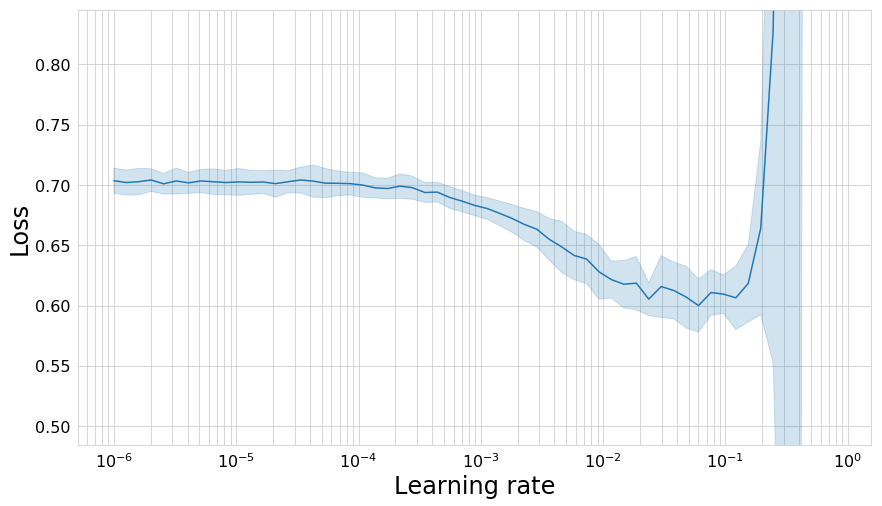

In [38]:
lr_finder = fold_lr_find(train_fy, model_builder, bs, lr_bounds=[1e-6,1e0])

In [39]:
callback_partials[0].keywords['lr_range'] = [3e-4, 3e-2]

Training model 1 / 1, Val ID = 0


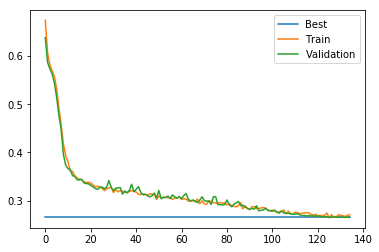

Early stopping after 135 epochs
Scores are: {'loss': 0.2654084265232086, 'AUC': 0.9524784565590915}
Fold took 282.320s


______________________________________
Training finished
Cross-validation took 282.331s 


<Figure size 432x288 with 0 Axes>

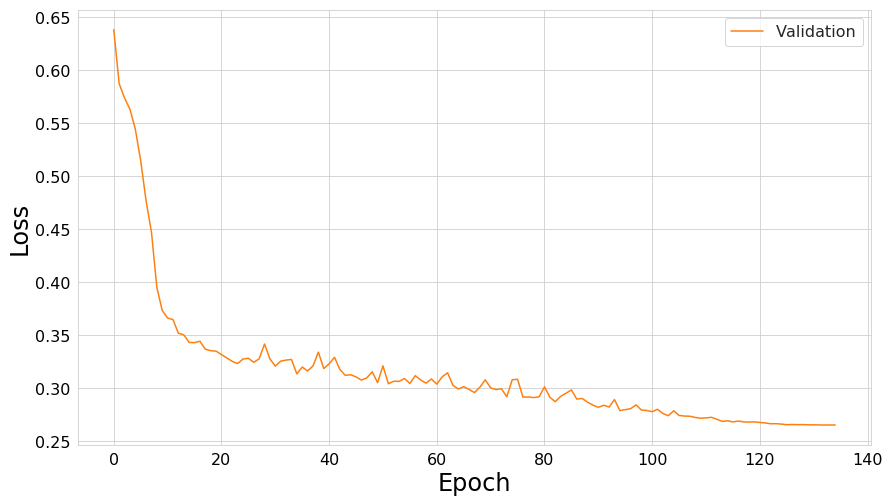

Mean loss = 0.2654084265232086±0.0
Mean AUC = 0.9524784565590915±0.0
______________________________________



In [40]:
_ = fold_train_ensemble(train_fy, n_models=1,
                        model_builder=model_builder,
                        bs=bs,
                        callback_partials=callback_partials,
                        eval_metrics=eval_metrics,
                        max_epochs=15, patience=15)

## ResNet

In [41]:
class ResNet(AbsConv1dHead):
    def get_layers(self, in_c:int, act:str='relu', bn:bool=False, **kargs) -> Tuple[nn.Module, int]:    
        layers = []
        layers.append(self.get_conv1d_block(in_c, 16, stride=1, kernel_sz=3, act='linear', bn=False))
        layers.append(self.get_conv1d_res_block(16, 16, stride=1, kernel_sz=3, act=act, bn=bn))
        layers.append(self.get_conv1d_res_block(16, 32, stride=2, kernel_sz=3, act=act, bn=bn))
        layers.append(nn.AdaptiveAvgPool1d(1))
        layers = nn.Sequential(*layers)
        return layers

In [42]:
head = partial(ResNet, vecs=vecs, feats_per_vec=fpv, act='swish', bn=True)
model_builder = get_model_builder(train_fy, depth=3, width=50, head=head)

Inputs:
60 Continuous: ['0_e', '0_px', '0_py', '0_pz', '1_e', '1_px', '1_py', '1_pz', '2_e', '2_px', '2_py', '2_pz', '3_e', '3_px', '3_py', '3_pz', '4_e', '4_px', '4_py', '4_pz', '5_e', '5_px', '5_py', '5_pz', '6_e', '6_px', '6_py', '6_pz', '7_e', '7_px', '7_py', '7_pz', '8_e', '8_px', '8_py', '8_pz', '9_e', '9_px', '9_py', '9_pz', '10_e', '10_px', '10_py', '10_pz', '11_e', '11_px', '11_py', '11_pz', '12_e', '12_px', '12_py', '12_pz', '13_e', '13_px', '13_py', '13_pz', '14_e', '14_px', '14_py', '14_pz']
                   
0  Categorical: []
                   
0  Matrix elements: []
                   

Model:
<bound method Module.parameters of Sequential(
  (0): ResNet(
    (layers): Sequential(
      (0): Conv1DBlock(
        (layers): Sequential(
          (0): Conv1d(4, 16, kernel_size=(3,), stride=(1,), padding=(1,))
        )
      )
      (1): Res1DBlock(
        (layers): Sequential(
          (0): Sequential(
            (0): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=Tr

LR finder took 54.199s 


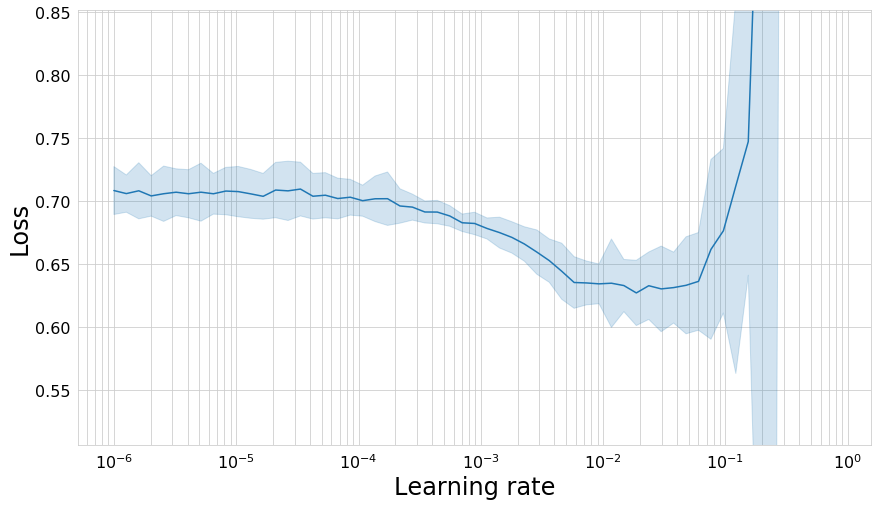

In [45]:
lr_finder = fold_lr_find(train_fy, model_builder, bs, lr_bounds=[1e-6,1e0])

In [46]:
callback_partials[0].keywords['lr_range'] = [1e-4, 1e-2]

Training model 1 / 1, Val ID = 0


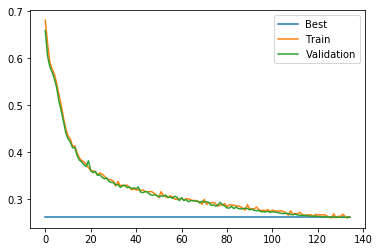

Early stopping after 135 epochs
Scores are: {'loss': 0.26185503602027893, 'AUC': 0.9535638281480926}
Fold took 300.596s


______________________________________
Training finished
Cross-validation took 300.607s 


<Figure size 432x288 with 0 Axes>

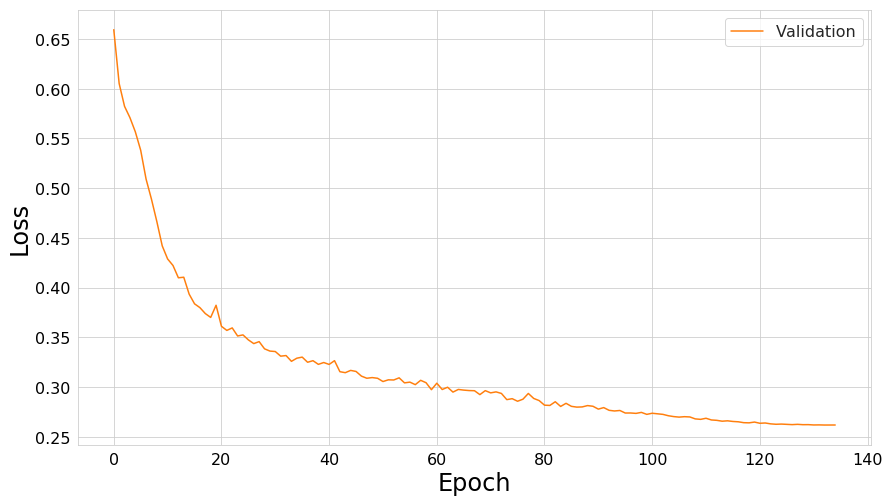

Mean loss = 0.26185503602027893±0.0
Mean AUC = 0.9535638281480926±0.0
______________________________________



In [47]:
_ = fold_train_ensemble(train_fy, n_models=1,
                        model_builder=model_builder,
                        bs=bs,
                        callback_partials=callback_partials,
                        eval_metrics=eval_metrics,
                        max_epochs=15, patience=15)

## ResNeXt

In [48]:
class ResNeXt(AbsConv1dHead):
    def get_layers(self, in_c:int, act:str='relu', bn:bool=False, **kargs) -> Tuple[nn.Module, int]:    
        layers = []
        layers.append(self.get_conv1d_block(in_c, 32, stride=1, kernel_sz=3, act='linear', bn=False))
        layers.append(self.get_conv1d_resNeXt_block(32, 4,4,32, stride=1, kernel_sz=3, act=act, bn=bn))
        layers.append(self.get_conv1d_resNeXt_block(32, 4,4,64, stride=2, kernel_sz=3, act=act, bn=bn))
        layers.append(nn.AdaptiveAvgPool1d(1))
        layers = nn.Sequential(*layers)
        return layers

In [49]:
head = partial(ResNeXt, vecs=vecs, feats_per_vec=fpv, act='swish', bn=True)
model_builder = get_model_builder(train_fy, depth=3, width=50, head=head)

Inputs:
60 Continuous: ['0_e', '0_px', '0_py', '0_pz', '1_e', '1_px', '1_py', '1_pz', '2_e', '2_px', '2_py', '2_pz', '3_e', '3_px', '3_py', '3_pz', '4_e', '4_px', '4_py', '4_pz', '5_e', '5_px', '5_py', '5_pz', '6_e', '6_px', '6_py', '6_pz', '7_e', '7_px', '7_py', '7_pz', '8_e', '8_px', '8_py', '8_pz', '9_e', '9_px', '9_py', '9_pz', '10_e', '10_px', '10_py', '10_pz', '11_e', '11_px', '11_py', '11_pz', '12_e', '12_px', '12_py', '12_pz', '13_e', '13_px', '13_py', '13_pz', '14_e', '14_px', '14_py', '14_pz']
                   
0  Categorical: []
                   
0  Matrix elements: []
                   

Model:
<bound method Module.parameters of Sequential(
  (0): ResNeXt(
    (layers): Sequential(
      (0): Conv1DBlock(
        (layers): Sequential(
          (0): Conv1d(4, 32, kernel_size=(3,), stride=(1,), padding=(1,))
        )
      )
      (1): ResNeXt1DBlock(
        (layers): Sequential(
          (0): Sequential(
            (0): BatchNorm1d(32, eps=1e-05, momentum=0.1, affi

LR finder took 56.218s 


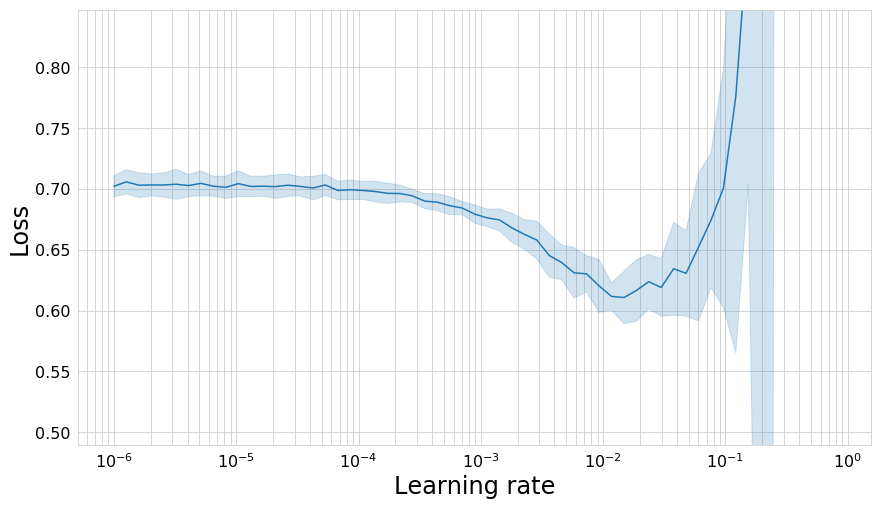

In [50]:
lr_finder = fold_lr_find(train_fy, model_builder, bs, lr_bounds=[1e-6,1e0])

In [51]:
callback_partials[0].keywords['lr_range'] = [1e-4, 1e-2]

Training model 1 / 1, Val ID = 0


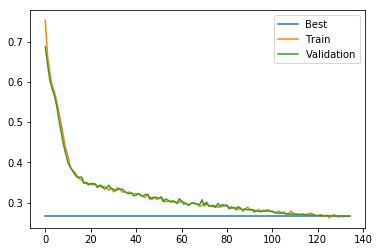

Early stopping after 135 epochs
Scores are: {'loss': 0.2660094201564789, 'AUC': 0.9511892356381063}
Fold took 315.830s


______________________________________
Training finished
Cross-validation took 315.841s 


<Figure size 432x288 with 0 Axes>

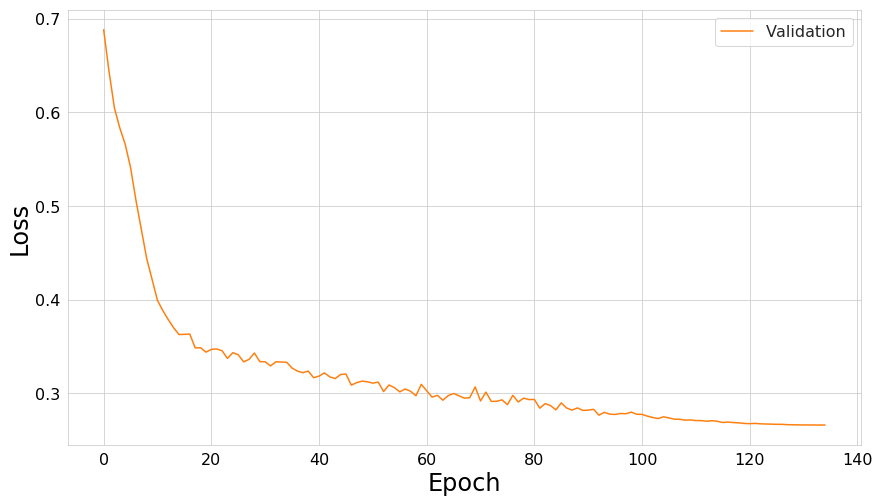

Mean loss = 0.2660094201564789±0.0
Mean AUC = 0.9511892356381063±0.0
______________________________________



In [52]:
_ = fold_train_ensemble(train_fy, n_models=1,
                        model_builder=model_builder,
                        bs=bs,
                        callback_partials=callback_partials,
                        eval_metrics=eval_metrics,
                        max_epochs=15, patience=15)

## Interaction Net

In [53]:
head = partial(InteractionNet, intfunc_depth=3,intfunc_width=20,intfunc_out_sz=10,
               outfunc_depth=3,outfunc_width=20,outfunc_out_sz=4,agg_method='flatten',
               feats_per_vec=fpv,vecs=vecs, act='swish')
model_builder = get_model_builder(train_fy, depth=3, width=50, head=head)

Inputs:
60 Continuous: ['0_e', '0_px', '0_py', '0_pz', '1_e', '1_px', '1_py', '1_pz', '2_e', '2_px', '2_py', '2_pz', '3_e', '3_px', '3_py', '3_pz', '4_e', '4_px', '4_py', '4_pz', '5_e', '5_px', '5_py', '5_pz', '6_e', '6_px', '6_py', '6_pz', '7_e', '7_px', '7_py', '7_pz', '8_e', '8_px', '8_py', '8_pz', '9_e', '9_px', '9_py', '9_pz', '10_e', '10_px', '10_py', '10_pz', '11_e', '11_px', '11_py', '11_pz', '12_e', '12_px', '12_py', '12_pz', '13_e', '13_px', '13_py', '13_pz', '14_e', '14_px', '14_py', '14_pz']
                   
0  Categorical: []
                   
0  Matrix elements: []
                   

Model:
<bound method Module.parameters of Sequential(
  (0): InteractionNet(
    (fr): Sequential(
      (0): Sequential(
        (0): Linear(in_features=8, out_features=20, bias=True)
        (1): Swish()
      )
      (1): Sequential(
        (0): Linear(in_features=20, out_features=20, bias=True)
        (1): Swish()
      )
      (2): Sequential(
        (0): Linear(in_features=20,

LR finder took 53.804s 


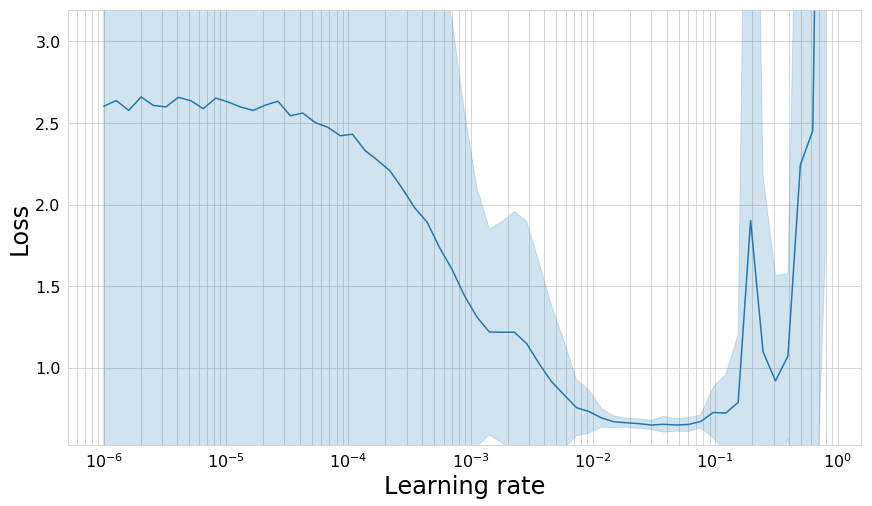

In [54]:
lr_finder = fold_lr_find(train_fy, model_builder, bs, lr_bounds=[1e-6,1e0])

In [55]:
callback_partials[0].keywords['lr_range'] = [3e-4, 3e-2]

Training model 1 / 1, Val ID = 0


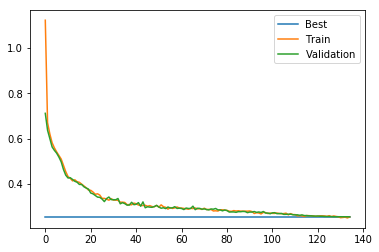

Early stopping after 135 epochs
Scores are: {'loss': 0.25612929463386536, 'AUC': 0.9554309146503004}
Fold took 319.477s


______________________________________
Training finished
Cross-validation took 319.489s 


<Figure size 432x288 with 0 Axes>

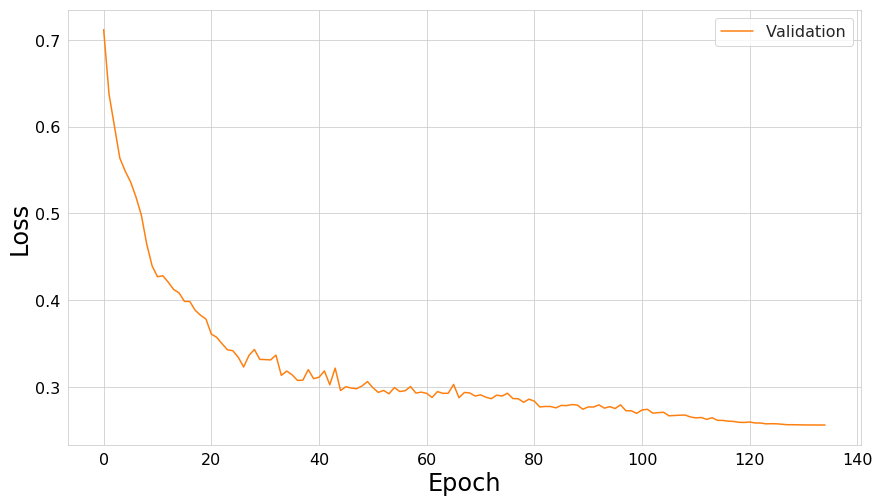

Mean loss = 0.25612929463386536±0.0
Mean AUC = 0.9554309146503004±0.0
______________________________________



In [56]:
_ = fold_train_ensemble(train_fy, n_models=1,
                        model_builder=model_builder,
                        bs=bs,
                        callback_partials=callback_partials,
                        eval_metrics=eval_metrics,
                        max_epochs=15, patience=15)